# Packages loading

In [2]:
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from scipy.signal import butter, lfilter
from statsmodels.tsa.ar_model import AR
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy import fftpack
from pandas import Series
from scipy import signal
from sklearn import tree
from numpy import diff
import pandas as pd
import numpy as np
import itertools
import pywt.data
import graphviz
import random
import h5py
import scipy
import time
import pywt

# Data Loading

In [3]:
trainx = h5py.File('./all/train.h5', 'r')
trainy = pd.read_csv('./all/train_y.csv')
testx = h5py.File('./all/test.h5', 'r')

# Data features and Visualization

In [4]:
print("Nom des colonnes (une colonne par type de signal) : \n")
print(list(trainx.keys()))

Nom des colonnes (une colonne par type de signal) : 

['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7', 'pulse_oximeter_infrared']


In [5]:
print("Dimension d'une colonne : \n")
print(trainx["eeg_1"].shape)

Dimension d'une colonne : 

(38289, 1500)


In [6]:
print("Données brutes : \n")
trainx["eeg_1"][0]

Données brutes : 



array([11.82449777, 11.79281851,  6.50667794, ..., 16.39350534,
       16.75841111, 15.7935009 ])

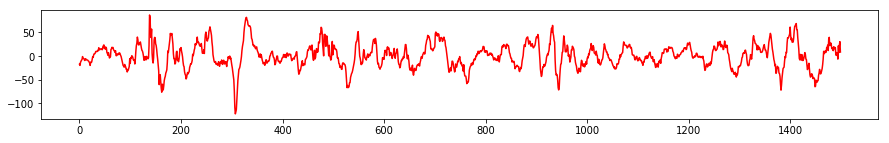

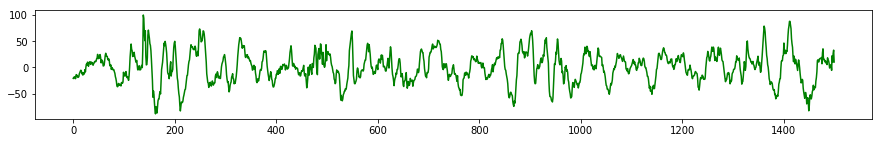

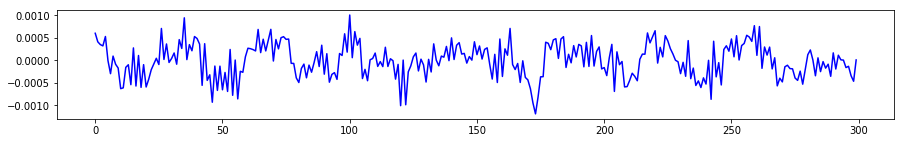

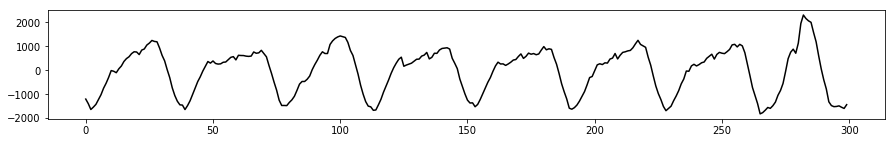

In [7]:
plt.figure(figsize=[15,2])
plt.plot(trainx["eeg_1"][1,:], 'r')
plt.figure(figsize=[15,2])
plt.plot(trainx["eeg_2"][1,:], 'green')
plt.figure(figsize=[15,2])
plt.plot(trainx["accelerometer_y"][1,:], 'blue')
plt.show()
plt.figure(figsize=[15,2])
plt.plot(trainx['pulse_oximeter_infrared'][1,:], 'black')
plt.show()

# Data structure functions

In [8]:
def to_pandas_column(data,col_name):
    df = pd.DataFrame(np.array(data[col_name][:]))
    return df

# Filtration

In [9]:
# Band-pass Butterworth Filter
def filter_band(signal,lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b, a = butter(order, [low, high], btype='bandpass')
    y = lfilter(b, a, signal)
    return y

# Low-pass Butterworth Filter
def filter_lowband(signal,lowcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut/nyq
    b, a = butter(order, low, btype='lowpass')
    y = lfilter(b, a, signal)
    return y

# High-pass Butterworth Filter
def filter_highband(signal,highcut, fs, order):
    nyq = 0.5 * fs
    high = highcut/nyq
    b, a = butter(order, high, btype='high')
    y = lfilter(b, a, signal)
    return y

# Tests and visualization

### Filtered signal in time domain : $\theta$ band

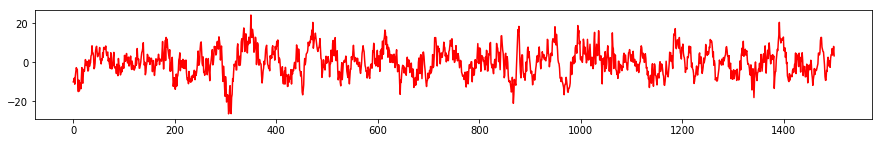

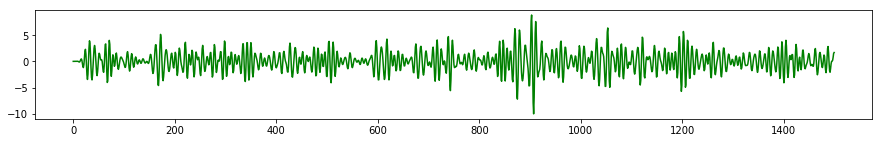

In [10]:
df = to_pandas_column(trainx,"eeg_1")
signal = df.loc[1000]
filtered = filter_band(signal,4,8, 50, 10)

plt.figure(figsize=[15,2])
plt.plot(trainx["eeg_1"][1000,:], 'r')
plt.figure(figsize=[15,2])
plt.plot(filtered, 'green')
plt.show()

### Filtered signal in frequency domain : $\theta$ band

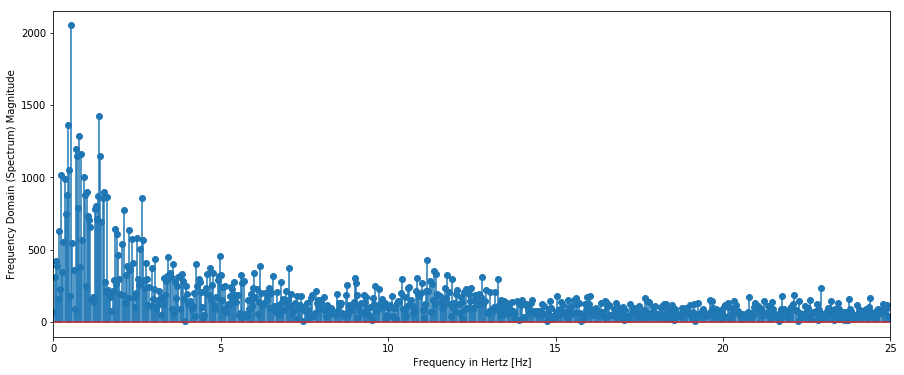

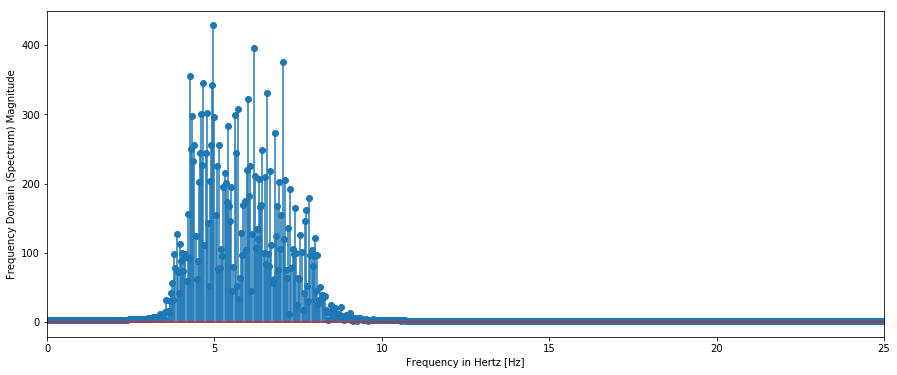

In [11]:
def plot_fft(data,fs):
    X = fftpack.fft(data)
    freqs = fftpack.fftfreq(data.size)*fs
    plt.figure(figsize=[15,6])
    plt.stem(freqs, np.abs(X))
    plt.xlabel('Frequency in Hertz [Hz]')
    plt.ylabel('Frequency Domain (Spectrum) Magnitude')
    plt.xlim([0, fs/2])
    plt.show()
    return np.abs(X), freqs

X, freqs = plot_fft(signal, 50)
X, freqs = plot_fft(filtered, 50)

# Features extraction

## $(1)$ EEG inputs

In [ ]:
band_filters = {'delta':[0,4],
               'theta':[4,8],
               'alpha':[8,13],
               'beta' : [13,22]}

### Classical Statistical features in time domain

In [ ]:
def df_stats(df,eeg_name,band_name):
    df_mean = df.apply(lambda row: pd.Series(np.mean(row)), axis=1)
    df_std = df.apply(lambda row: pd.Series(np.std(row)), axis=1)
    df_skew = df.apply(lambda row: pd.Series(scipy.stats.skew(row, axis=0, bias=True)), axis=1)
    df_kurtosis = df.apply(lambda row: pd.Series(scipy.stats.kurtosis(row, axis=0, bias=True)), axis=1)
    col_names = [eeg_name+'_'+band_name+'_mean',
                 eeg_name+'_'+band_name+'_std',
                 eeg_name+'_'+band_name+'_skew',
                 eeg_name+'_'+band_name+'_kurtosis']
    result_concat = pd.concat([df_mean, df_std, df_skew, df_kurtosis],axis=1)
    result_concat.columns = col_names
    return result_concat

### Other time domain features

In [ ]:
def shannon_entropy(data):
    sum_data = np.sum(np.array(np.abs(data)))
    return -np.sum(np.array([np.log(np.abs(elem)/sum_data)*np.abs(elem)/sum_data for elem in data]))

def hjorth_parameters(data):
    derivative1 = diff(data)
    derivative2 = diff(derivative1)
    complexity = np.sqrt(np.std(derivative1)/np.std(data))
    morbidity = (np.sqrt(np.std(derivative2)/np.std(derivative1)))/(complexity)
    return np.array([complexity, morbidity])

def df_time(df,eeg_name,band_name):
    df_entropy = df.apply(lambda row: pd.Series(shannon_entropy(row)), axis=1)
    df_hjorth_complexity = df.apply(lambda row: pd.Series(hjorth_parameters(row)[0]), axis=1)
    df_hjorth_morbidity = df.apply(lambda row: pd.Series(hjorth_parameters(row)[1]), axis=1)
    col_names = [eeg_name+'_'+band_name+'_entropy',
                 eeg_name+'_'+band_name+'_hjorth_complexity',
                 eeg_name+'_'+band_name+'_hjorth_morbidity']
    df_result = pd.concat([df_entropy, df_hjorth_complexity, df_hjorth_morbidity], axis=1) 
    df_result.columns = col_names
    return df_result

### Energy (frequency domain)

In [ ]:
def energy(data):
    return sum(map(lambda x:x*x,data))

def df_freq(df,eeg_name,band_name):
    df_energy = df.apply(lambda row: pd.Series(energy(row)), axis=1)
    col_names = [eeg_name+'_'+band_name+'_energy']
    df_energy.columns = col_names
    return df_energy

### Dataset formation

In [ ]:
def df_compute_features_band(df,eeg_name,band_name):
    df_0 = df_stats(df,eeg_name,band_name)
    df_1 = df_time(df,eeg_name,band_name)
    df_2 = df_freq(df,eeg_name,band_name)
    return pd.concat([df_0, df_1, df_2], axis=1) 

def filter_input_eeg(data,name):
    df_eeg = to_pandas_column(data,name)
    dict_eeg = dict.fromkeys(list(band_filters.keys()))
    df_eeg_result = df_eeg.apply(lambda row: filter_lowband(row, 4, 50, 10), axis=1)
    df_eeg_result = df_compute_features_band(df_eeg_result,name,'delta')
    n=len(list(band_filters.keys()))
    for band in list(band_filters.keys())[1:n]:
        print(band)
        low, high = band_filters[band][0], band_filters[band][1]
        df_eeg_band_new = df_eeg.apply(lambda row: filter_band(row, low, high, 50, 10), axis=1)
        df_eeg_band_new = df_compute_features_band(df_eeg_band_new,name,band)
        df_eeg_result = pd.concat([df_eeg_result, df_eeg_band_new], axis=1)   
    return df_eeg_result

## $(2)$ Accelerometer inputs

In [ ]:
def df_stats_global(df,acc_name):
    print(acc_name)
    df_mean = df.apply(lambda row: np.mean(row), axis=1)
    df_std = df.apply(lambda row: np.std(row), axis=1)
    df_skew = df.apply(lambda row: scipy.stats.skew(row, axis=0, bias=True), axis=1)
    df_kurtosis = df.apply(lambda row: scipy.stats.kurtosis(row, axis=0, bias=True), axis=1)
    df_max = df.apply(lambda row : max(row), axis=1)
    df_min = df.apply(lambda row : min(row), axis=1)
    col_names = [acc_name+'_skew',
                 acc_name+'_kurtosis']
    result_concat = pd.concat([df_skew, df_kurtosis], axis=1)
    result_concat.columns = col_names
    return result_concat

## $(3)$ Heart-beat input

### AutoRegression coefficients (time domaine)

In [ ]:
def ar_coeffs(data):
    series = data.as_matrix()
    model = AR(series)
    model_fit = model.fit()
    coeffs = model_fit.params
    return coeffs

In [ ]:
def df_ar_time(df,input_name):
    df_ar = df.apply(lambda row: pd.Series(ar_coeffs(row)), axis=1)
    n = len(df_ar.loc[0])
    col_names = ['coeff_ar'+'_'+str(elem)+'_'+input_name for elem in list(range(0,n))]
    df_ar.columns = col_names
    return df_ar

### Signal energy (frequency domain)

In [ ]:
def df_freq_global(df,input_name):
    df_energy = df.apply(lambda row: pd.Series(energy(row)), axis=1)
    col_names = [input_name+'_energy']
    df_energy.columns = col_names
    return df_energy

### Wavelet Transform (time-frequency domain)

In [ ]:
# see above functions df_freq_time

In [ ]:
def df_process_hb(df,input_name): #hb for heart beat
    df_ar_coeffs = df_ar_time(df,input_name)
    df_energy = df_freq_global(df,input_name)
    #df_wt = df_freq_time(df,input_name,wt_level=5)
    df_result = pd.concat([df_ar_coeffs, df_energy],axis=1)
    return df_result

# Final Dataset

In [ ]:
def df_preprocess(data):
    
    # eeg pre-processing
    eeg_cols = [elem for elem in list(data.keys()) if (elem[0:3] == 'eeg')][1:7]
    df_filtered_eeg = filter_input_eeg(data,"eeg_1") 
    for eeg in eeg_cols:
        df_filtered_eeg_new = filter_input_eeg(data, eeg)
        df_filtered_eeg = pd.concat([df_filtered_eeg, df_filtered_eeg_new], axis=1) 
    print(df_filtered_eeg.shape)
    
    # acc signal pre-processing
    acc_cols = [elem for elem in list(data.keys()) if (elem[0:3] == 'acc')]
    df_acc = to_pandas_column(data,acc_cols[0])
    df_processed_acc = df_stats_global(df_acc,acc_cols[0]) 
    for acc in acc_cols[1:len(acc_cols)]:
        df_processed_acc_new = df_stats_global(df_acc,acc) 
        df_processed_acc = pd.concat([df_processed_acc,df_processed_acc_new], axis=1)
    print(df_processed_acc.shape)
    
    # pulse signal pre-processing
    df_hb = to_pandas_column(data,'pulse_oximeter_infrared')
    df_processed_hb = df_process_hb(df_hb,'pulse_oximeter_infrared') 
    print(df_processed_hb.shape)
    
    # concatenation of features
    df_final = pd.concat([df_filtered_eeg, df_processed_acc, df_processed_hb], axis=1)
        
    return df_final

In [ ]:
df_final_train = df_preprocess(trainx)

In [13]:
df_final_train = pd.read_csv('./all/df_final_train.csv')

# Model training

Number of data of class n°0:
3619


Number of data of class n°1:
1353


Number of data of class n°2:
17132


Number of data of class n°3:
5731


Number of data of class n°4:
10454




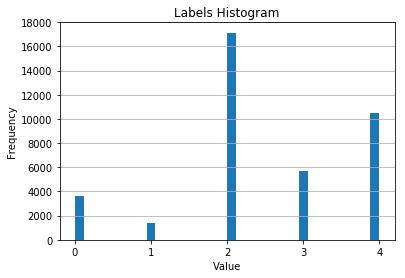

In [14]:
labels = pd.DataFrame(data = trainy['sleep_stage'], columns = ["sleep_stage"]) #labels

# Labels counting
for i in range(0,5):
    print("Number of data of class n°"+str(i)+":")
    print(len(labels[labels['sleep_stage'] == i]))
    print("\n")

# labels distribution
n, bins, patches = plt.hist(x=labels, bins='auto')
plt.grid(axis='y')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Labels Histogram')
plt.show()

In [15]:
df_total = pd.concat([df_final_train,labels], axis=1)

### Class balancing and shuffling

In [ ]:
#df_total_balanced = df_total.groupby('sleep_stage')
#df_total_balanced = df_total_balanced.apply(lambda x: x.sample(df_total_balanced.size().min()).reset_index(drop=True))

In [16]:
df_total = shuffle(df_total)

### Train and Validation set split

In [17]:
df_train ,df_validation = train_test_split(df_total,test_size=0.05) 

In [18]:
# Labels counting after balancing
for i in range(0,5):
    print("Number of data of class n°"+str(i)+":")
    print(len(df_train[df_train['sleep_stage'] == i]))

Number of data of class n°0:
3418
Number of data of class n°1:
1285
Number of data of class n°2:
16319
Number of data of class n°3:
5443
Number of data of class n°4:
9909


### Meta-Parameters

In [19]:
n_estimators = 1000

## Model training

### Random Forest

In [ ]:
# Model training
model_rf = RandomForestClassifier(n_estimators=n_estimators, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model_rf.fit(df_train.loc[:, df_train.columns != 'sleep_stage'], df_train['sleep_stage'])

### Cross-validation

In [ ]:
scores = cross_val_score(model_rf, df_train.loc[:, df_train.columns != 'sleep_stage'], df_train['sleep_stage'], cv=5, scoring='f1_macro')

In [ ]:
scores

In [ ]:
y_true = df_validation['sleep_stage']

In [ ]:
y_pred = model_rf.predict(df_validation.loc[:, df_validation.columns != 'sleep_stage'])
Score = f1_score(y_pred, y_true, average='macro')

In [ ]:
Score

### Confusion Matrix (see where the model perform the best and the least)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure()
plot_confusion_matrix(conf_mat, classes=np.unique(y_pred),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=np.unique(y_pred), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Features importance visualization

In [ ]:
N = 20
importances = model_rf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             #axis=0)
indices = np.argsort(importances)[::-1][0:N]&
names = [df_train.columns[ind] for ind in indices]

In [ ]:
# Print the feature ranking
print("Feature ranking:")

for f in range(N):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(N), importances[indices],
       color="b", align="center") #yerr=std[indices],
plt.xticks(range(N), names)
plt.xticks(rotation=90)
plt.xlim([-1, N])
plt.show()

In [ ]:
df_features_imp = df_train[names]
df_features_imp.describe()

# Submission test formatting

In [ ]:
df_final_test = df_preprocess(testx)

In [ ]:
df_final_test.to_csv('./all/df_final_test.csv')

In [ ]:
df_final_test = pd.read_csv('./all/df_final_test.csv')

### Prediction on Test Dataset

In [ ]:
y_pred_test = model_rf.predict(df_final_test)

In [ ]:
y_pred_test.shape

In [ ]:
y_pred_test

In [ ]:
# Labels counting after balancing
for i in range(0,5):
    print("Number of data of class n°"+str(i)+":")
    print((y_pred_test == i).sum())

### Submission

In [ ]:
import time
submission = pd.Series(y_pred_test, name= 'sleep_stage')
submission.to_csv('./all/'+ 'Prediction'+str(time.time())+'.csv', header=True, float_format = True, index_label='id' )